# ADVERSARIAL EXAMPLES WITH PYTORCH

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Device configuration
print(torch.__version__)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

1.9.0+cu102
cpu


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pretrained_model = "/content/drive/MyDrive/Adversarial-examples-implementation/pretrainer-mnist/lenet_mnist_model.pth"

In [ ]:
# How to get number of classes from .pth file without any model information in Python?

checkpoint = torch.load(pretrained_model, map_location=device)

last_key = list(checkpoint)[-1]
print(checkpoint[last_key].size())

# or

# model = torch.load('path to the model')
# last_key = list(model['model'].values())[-1]
# key_length = list(map(model['model'].get, last_key))
# print((key_length))

torch.Size([10])


In [89]:
# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.softmax(x, dim=1) # F.log_softmax(x, dim=1)

In [90]:
# MNIST Train, Test dataset and dataloader declaration
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                    ])),
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])), 
        batch_size=1, shuffle=True)

In [91]:
# Initialize the network
model = Net()

# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

<All keys matched successfully>

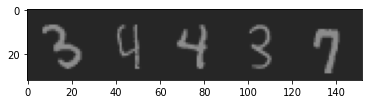

In [92]:
# Example of images in MNIST dataset
mean = torch.tensor([0.1520], dtype=torch.float32)
std = torch.tensor([0.4051], dtype=torch.float32)
inverse_transform = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())
images, _ = next(iter(train_loader))
grid = inverse_transform(torchvision.utils.make_grid(images[0:5], nrow=5).permute(1, 2, 0))
plt.imshow(grid)
plt.show()

## Fast Gradient Sign Method (FGSM)

We have an input $x$, which is correctly classified by a model. So we want to find an adversarial example  $\mathbf{\tilde{x}}$, which is perceptually indistinguishable from original input $\mathbf{x}$, such that it will be misclassified by that same model. To do that we can add an adversarial perturbation ($\eta$) to the original input (i.e. $\mathbf{\tilde{x}} = \mathbf{x} + \eta$). Note that we want adversarial example to be indistinguishable from the original one. That can be achieved by constraining the magnitude of adversarial perturbation:  $||\eta||_{\infty} = ||\mathbf{\tilde{x}} - \mathbf{x}||_{\infty} \leq \epsilon$ . That is, the $L_{\infty}$  norm should be less than epsilon. Here, $L_{\infty}$  denotes the maximum changes for all pixels in adversarial example. **F**ast **G**radient **S**ign **M**ethod (**FGSM**) is a fast and computationally efficient method to generate adversarial examples. However, it usually has a lower success rate. The formula to find adversarial example is as follows:
$$ \mathbf{x}^{\mbox{adv}} = \mathbf{x} + \epsilon * sign(\nabla_x J(\mathbf{\theta}, \mathbf{x}, y)). $$

Since we passe an image into the CNN we can write it in terms of image like:
$$ perturbed\_image = image + epsilon*sign(data\_grad).  $$

Finally, in order to maintain the original range of the data, the perturbed image is clipped to range  [0,1].

In [93]:
# This function "FGSM" creates the adversarial examples by perturbing the original inputs.
# The function then creates perturbed image : x_adv

def FGSM(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon * sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

## Test function

In [94]:
# # Hyper-parameters
# learning_rate = 0.1
# momentum = 0.9

## Optimization
#criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model_1.parameters(), lr=learning_rate, momentum=momentum)
optimizer = torch.optim.Adadelta(model.parameters(), 1.0)

In [95]:
def test( model, device, test_loader, epsilon ):
    
    # Set the model in evaluation mode. In this case this is for the Dropout layers
    model.eval()
    model.to(device)

    # Accuracy counter
    incorrect = 0
    correct = 0
    adv_examples = []
    confidence = 0

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        
        confidence += torch.abs(torch.max(output))


        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            incorrect += 1
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Backward pass: calculate gradients of model in backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = FGSM(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            incorrect += 1
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )


    # Accuracy for this epsilon
    accuracy = correct/float(len(test_loader))

    # Error rate 
    error = incorrect/float(len(test_loader))

    # Confidence rate
    confidence = confidence/float(len(test_loader))

    print("---------"*11)
    print(f"Epsilon : {epsilon}  ||  "
          f"Test accuracy : {100 * accuracy:.2f} %  ||  "
          f"Error rate : {100 * error:.2f} %  || "
          f"Confidence rate : {100 * confidence:.2f} %")

    # Return the accuracy and an adversarial example
    return accuracy, adv_examples

## Experiments

In [96]:
epsilons = [0, .05, .1, .15, .2, .25, .3] # epsilons = 0 case represents the original test accuracy
accuracies = []
examples = []


# Start test function for each epsilon in epsilons list
print()
print("Training started...")
print()
for i in epsilons:
    acc, adv_ex = test(model, device, test_loader, i)
    accuracies.append(acc)
    examples.append(adv_ex)


print("---------"*11)
print()
print("Training finished!")
print()


Training started...

---------------------------------------------------------------------------------------------------
Epsilon : 0  ||  Test accuracy : 96.00 %  ||  Error rate : 4.00 %  || Confidence rate : 99.01 %
---------------------------------------------------------------------------------------------------
Epsilon : 0.05  ||  Test accuracy : 95.65 %  ||  Error rate : 4.35 %  || Confidence rate : 99.51 %
---------------------------------------------------------------------------------------------------
Epsilon : 0.1  ||  Test accuracy : 85.36 %  ||  Error rate : 14.64 %  || Confidence rate : 99.63 %
---------------------------------------------------------------------------------------------------
Epsilon : 0.15  ||  Test accuracy : 72.66 %  ||  Error rate : 27.34 %  || Confidence rate : 99.75 %
---------------------------------------------------------------------------------------------------
Epsilon : 0.2  ||  Test accuracy : 52.60 %  ||  Error rate : 47.40 %  || Confidence 

## Graph of the test accuracy

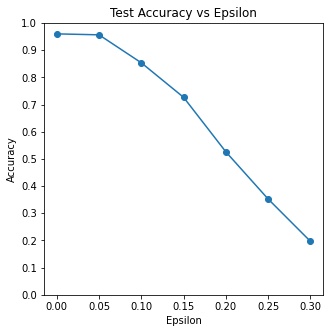

In [97]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "o-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Test Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.savefig("test_accuracy_vs_epsilon_Sof.png", dpi = 300)
plt.show()

## Sample adversarial example

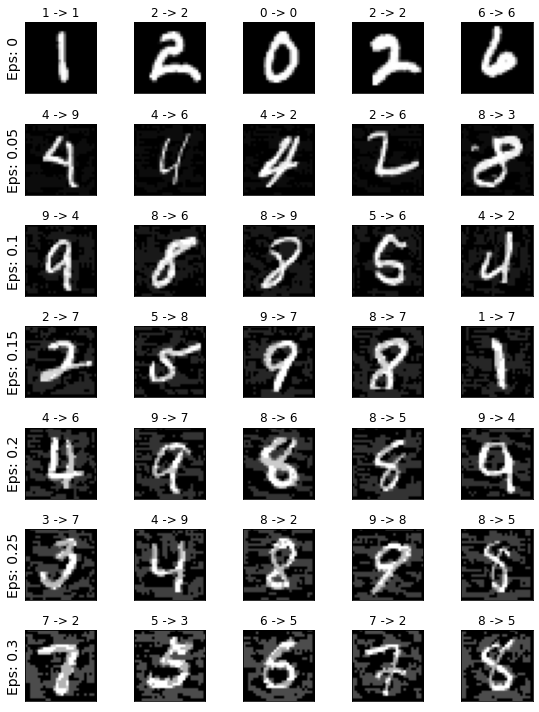

In [98]:
# Plot several examples of adversarial samples at each epsilon
"""
original classification --> adversarial classification
"""
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

In [ ]:
!pwd
!tree

/content
/bin/bash: tree: command not found
